In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports and Paths

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import copy
import sklearn
import rastermap
import pandas as pd

import tensorly as tl
import tensorly.decomposition

In [3]:
dir_github        = Path(r'/n/data1/hms/neurobio/sabatini/gyu/github_clone').resolve()

dir_analysisFiles = Path(r'/n/data1/hms/neurobio/sabatini/gyu/data_done/mouse_1511L/20230111/analysis_data').resolve()

## Directory with F.npy, stat.npy etc.
dir_s2p         = Path(r'/n/data1/hms/neurobio/sabatini/gyu/data_done/mouse_1511L/20230111/analysis_data/suite2p/plane0').resolve()
# dir_s2p         = Path(r'C:\Users\Rich Hakim\Downloads\F.npy').resolve()

## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN_tqm.npy'

## Path of tqm (trace quality metrics). Used to get dFoF parameters
path_tqm = dir_analysisFiles / 'trace_quality.pkl'


dir_save       =  copy.copy(dir_analysisFiles)
path_save = dir_save / 'weights_day0'
# path_save = dir_save / 'weights_day0_PC2'

In [4]:
import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2

from bnpm import torch_helpers, file_helpers, timeSeries, ca2p_preprocessing, welford_moving_2D, linear_regression, similarity

%load_ext autoreload
%autoreload 2
from Big_Ugly_ROI_Tracker.multiEps.multiEps_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def get_highest_evr_var(data, factors,  hits):
    evrs = np.zeros(factors.shape[0])
    for i, factor in enumerate(factors):
        _,_,_,evr_total = similarity.orthogonalize(data, factor)
        evrs[i] = evr_total
    evrs[np.logical_not(hits)] = 0
    highest_evr_ind = np.argsort(evrs)[-1]
    return highest_evr_ind, factors[highest_evr_ind,:], evrs

def orthogonalize_simple(data, factor):
    proj_vec = similarity.proj(data, factor)[0]
    return (np.squeeze(data) - np.squeeze(proj_vec))

In [6]:
DEVICE = torch_helpers.set_device(use_GPU=True)

devices available: [_CudaDeviceProperties(name='Quadro RTX 6000', major=7, minor=5, total_memory=22698MB, multi_processor_count=72)]
Using device: 'cuda:0': _CudaDeviceProperties(name='Quadro RTX 6000', major=7, minor=5, total_memory=22698MB, multi_processor_count=72)


In [7]:
iscell = np.load(path_iscell)
# spks = np.load(path_spks)

In [8]:
tqm = file_helpers.pickle_load(path_tqm)
dFoF_params = tqm['dFoF_params']

In [9]:
## == IMPORT DATA ==
F = np.load(dir_s2p / 'F.npy') # masks multiplied by data
Fneu = np.load(dir_s2p / 'Fneu.npy') # estimated neuropil signal (Fns = F - Fneu; Fo = ptile(Fns, 30); dFoF=Fns-Fo/Fo)
# iscell = np.load(dir_s2p/'iscell.npy') # probability and bool of each roi
ops = np.load(dir_s2p / 'ops.npy', allow_pickle=True) # parameters for the suite2p
spks_s2p = np.load(dir_s2p / 'spks.npy') # blind deconvolution
stat = np.load(dir_s2p / 'stat.npy', allow_pickle=True) # statistics for individual neurons 

num_frames_S2p = F.shape[1]
Fs = ops[()]['fs']

In [10]:
# # Oopsie!
# # Mouse g2FB: delete 43000 - 50000 frames
# F = np.delete(F, range(43000,50000), axis=1)
# Fneu = np.delete(Fneu, range(43000,50000), axis=1)

In [11]:
Fneu.shape

(3608, 108000)

In [12]:
frame_height = ops[()]['meanImg'].shape[0]
frame_width = ops[()]['meanImg'].shape[1]

sf = import_and_convert_to_CellReg_spatialFootprints([dir_s2p / 'stat.npy'], frame_height=frame_height, frame_width=frame_width, dtype=np.float32)[0]

In [13]:
F_toUse = F[iscell]
Fneu_toUse = Fneu[iscell]

# Prepare dFoF

In [14]:
win_smooth = 4
kernel_smoothing = np.zeros(win_smooth*2)
kernel_smoothing[win_smooth:] = 1
kernel_smoothing /= kernel_smoothing.sum()

In [15]:
# Pipeline for the NMF Strategy 
# Smooth F
F_smooth = timeSeries.convolve_along_axis(
    F_toUse,
    kernel=kernel_smoothing,
    axis=1,mode='same',
    multicore_pref=True,
    verbose=True
).astype(np.float32)

# dFoF with reduced percentile for baseline
channelOffset_correction = 500
percentile_baseline = 5
neuropil_fraction=0.7

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(
    F=F_smooth + channelOffset_correction,
    Fneu=Fneu_toUse + channelOffset_correction,
    neuropil_fraction=neuropil_fraction,
    percentile_baseline=percentile_baseline,
    multicore_pref=True,
    verbose=True
)
# Threshold for nonnegativity
dFoF_z = dFoF / np.std(dFoF,axis=1,keepdims=True)

100%|██████████| 846/846 [00:00<00:00, 61653.08it/s]


ThreadPool elapsed time : 0.24 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 0.52 seconds
Calculated dFoF. Total elapsed time: 10.19 seconds


In [16]:
# Test out rolling subtraction of the 10th percentile of the daa to remove microscope movement artifacts

ptile = 10
window = int(Fs*60*1)

dFoF_sub_ptile = dFoF - timeSeries.rolling_percentile_pd(dFoF, ptile=ptile, window=window)
# dFoF_sub_ptile = dFoF - timeSeries.rolling_percentile_rq_multicore(dFoF, ptile=ptile, window=window)
# dFoF_sub_ptile_clipped = np.clip(dFoF_sub_ptile, a_min=0, a_max=None)

In [17]:
# Clip to remove any remnent artifact & make data non-negative
dFoF_sub_ptile_clipped = np.clip(dFoF_sub_ptile, a_min=0.2, a_max=None)

dFoF_sub_ptile_clipped_ms = dFoF_sub_ptile_clipped - dFoF_sub_ptile_clipped.mean(x, keepdims=True)

dFoF_sub_ptile_clipped = np.clip(tester, a_min=0.2, a_max=None)

### Look at rastermap

In [18]:
import rastermap

In [19]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [20]:
# rmap.fit(dFoF_sub_ptile)
rmap.fit(dFoF_sub_ptile_clipped)
# rmap.fit(scipy.stats.zscore(dFoF))

nmin 200
0.3367602825164795
6.126161813735962
6.473074436187744
6.475481748580933
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.21s     0        0.1564      2
0.23s    10        0.2912      4
0.25s    20        0.3278      8
0.27s    30        0.4133      18
0.29s    40        0.4639      28
0.31s    50        0.5173      38
0.33s    60        0.5175      38
0.34s   final      0.5175
0.34s upsampled    0.5175


<IPython.core.display.Javascript object>


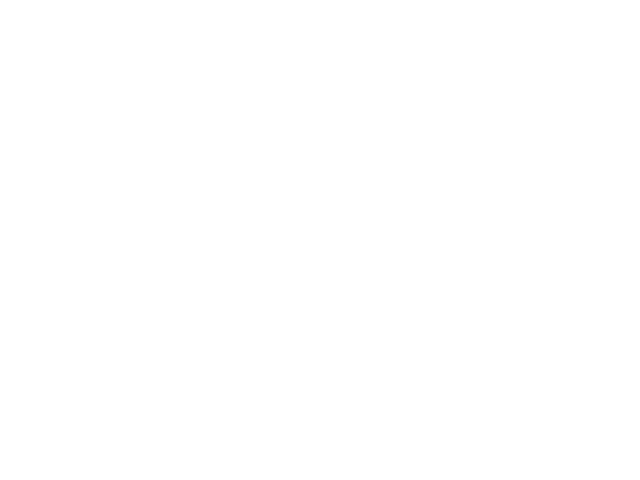

In [21]:
%matplotlib notebook

plt.figure()
# plt.imshow(dFoF_sub_ptile[rmap.isort], aspect='auto', vmax=1)
# plt.imshow(np.clip(scipy.stats.zscore(dFoF_sub_ptile, axis=1), -1,1)[rmap.isort], aspect='auto', vmax=1)
plt.imshow(dFoF_sub_ptile_clipped[rmap.isort], aspect='auto', vmin=-0.2, vmax=1)
# plt.imshow(scipy.stats.zscore(dFoF)[rmap.isort], aspect='auto', vmin=-0.1, vmax=1)

# Run NMF

In [336]:
# indices_cropped = np.arange(int(Fs*60*23),dFoF_sub_ptile.shape[1])

In [18]:
# neural_data_toUse =dFoF / np.std(dFoF,axis=1,keepdims=True)
# neural_data_toUse = (dFoF_sub_ptile / np.std(dFoF_sub_ptile,axis=1,keepdims=True))[:,indices_cropped]
neural_data_toUse = (dFoF_sub_ptile_clipped / np.std(dFoF_sub_ptile_clipped,axis=1,keepdims=True))

In [19]:
tl.set_backend('pytorch')

In [20]:
neural_data_toUse = tl.tensor(neural_data_toUse).to('cuda')

In [21]:
# Roll a dice and wish for luck
rank = 10

In [341]:
factors_nmf = tl.decomposition.non_negative_parafac(
            neural_data_toUse,
            rank=rank,
            n_iter_max=1000,
            init='random',
            svd='numpy_svd', 
            tol=1e-07,
        #     random_state=None,
            verbose=1,
        #     normalize_factors=False,
        #     return_errors=False,
        #     mask=None,
        #     cvg_criterion='abs_rec_error',
        #     fixed_modes=None
        )

reconstruction error=0.19661574065685272
iteration 1, reconstraction error: 0.19418169558048248, decrease = 0.0024340450763702393
iteration 2, reconstraction error: 0.19207856059074402, decrease = 0.0021031349897384644
iteration 3, reconstraction error: 0.19024042785167694, decrease = 0.0018381327390670776
iteration 4, reconstraction error: 0.18862511217594147, decrease = 0.0016153156757354736
iteration 5, reconstraction error: 0.18719330430030823, decrease = 0.0014318078756332397
iteration 6, reconstraction error: 0.1859154850244522, decrease = 0.001277819275856018
iteration 7, reconstraction error: 0.1847711205482483, decrease = 0.0011443644762039185
iteration 8, reconstraction error: 0.1837397962808609, decrease = 0.0010313242673873901
iteration 9, reconstraction error: 0.18280665576457977, decrease = 0.0009331405162811279
iteration 10, reconstraction error: 0.18195872008800507, decrease = 0.000847935676574707
iteration 11, reconstraction error: 0.18118572235107422, decrease = 0.000

iteration 105, reconstraction error: 0.16891540586948395, decrease = 1.6644597053527832e-05
iteration 106, reconstraction error: 0.16889925301074982, decrease = 1.615285873413086e-05
iteration 107, reconstraction error: 0.16888310015201569, decrease = 1.615285873413086e-05
iteration 108, reconstraction error: 0.16886793076992035, decrease = 1.5169382095336914e-05
iteration 109, reconstraction error: 0.16885323822498322, decrease = 1.4692544937133789e-05
iteration 110, reconstraction error: 0.16883854568004608, decrease = 1.4692544937133789e-05
iteration 111, reconstraction error: 0.16882386803627014, decrease = 1.4677643775939941e-05
iteration 112, reconstraction error: 0.1688096672296524, decrease = 1.4200806617736816e-05
iteration 113, reconstraction error: 0.16879546642303467, decrease = 1.4200806617736816e-05
iteration 114, reconstraction error: 0.16878272593021393, decrease = 1.2740492820739746e-05
iteration 115, reconstraction error: 0.16876952350139618, decrease = 1.320242881774

iteration 199, reconstraction error: 0.16819846630096436, decrease = 3.4421682357788086e-06
iteration 200, reconstraction error: 0.16819404065608978, decrease = 4.425644874572754e-06
iteration 201, reconstraction error: 0.168190598487854, decrease = 3.4421682357788086e-06
iteration 202, reconstraction error: 0.16818666458129883, decrease = 3.933906555175781e-06
iteration 203, reconstraction error: 0.16818274557590485, decrease = 3.919005393981934e-06
iteration 204, reconstraction error: 0.16817831993103027, decrease = 4.425644874572754e-06
iteration 205, reconstraction error: 0.1681748777627945, decrease = 3.4421682357788086e-06
iteration 206, reconstraction error: 0.16817143559455872, decrease = 3.4421682357788086e-06
iteration 207, reconstraction error: 0.16816702485084534, decrease = 4.410743713378906e-06
iteration 208, reconstraction error: 0.16816259920597076, decrease = 4.425644874572754e-06
iteration 209, reconstraction error: 0.1681591421365738, decrease = 3.4570693969726562e-0

iteration 292, reconstraction error: 0.1678457409143448, decrease = 3.948807716369629e-06
iteration 293, reconstraction error: 0.16784131526947021, decrease = 4.425644874572754e-06
iteration 294, reconstraction error: 0.16783785820007324, decrease = 3.4570693969726562e-06
iteration 295, reconstraction error: 0.16783343255519867, decrease = 4.425644874572754e-06
iteration 296, reconstraction error: 0.1678299754858017, decrease = 3.4570693969726562e-06
iteration 297, reconstraction error: 0.16782556474208832, decrease = 4.410743713378906e-06
iteration 298, reconstraction error: 0.16782161593437195, decrease = 3.948807716369629e-06
iteration 299, reconstraction error: 0.1678161919116974, decrease = 5.424022674560547e-06
iteration 300, reconstraction error: 0.167813241481781, decrease = 2.950429916381836e-06
iteration 301, reconstraction error: 0.16780880093574524, decrease = 4.4405460357666016e-06
iteration 302, reconstraction error: 0.16780585050582886, decrease = 2.950429916381836e-06
i

iteration 384, reconstraction error: 0.16747106611728668, decrease = 3.933906555175781e-06
iteration 385, reconstraction error: 0.1674685776233673, decrease = 2.4884939193725586e-06
iteration 386, reconstraction error: 0.16746415197849274, decrease = 4.425644874572754e-06
iteration 387, reconstraction error: 0.16746069490909576, decrease = 3.4570693969726562e-06
iteration 388, reconstraction error: 0.1674567461013794, decrease = 3.948807716369629e-06
iteration 389, reconstraction error: 0.16745181381702423, decrease = 4.932284355163574e-06
iteration 390, reconstraction error: 0.16744835674762726, decrease = 3.4570693969726562e-06
iteration 391, reconstraction error: 0.16744489967823029, decrease = 3.4570693969726562e-06
iteration 392, reconstraction error: 0.1674414426088333, decrease = 3.4570693969726562e-06
iteration 393, reconstraction error: 0.16743749380111694, decrease = 3.948807716369629e-06
iteration 394, reconstraction error: 0.16743354499340057, decrease = 3.948807716369629e-

iteration 474, reconstraction error: 0.16716179251670837, decrease = 2.9653310775756836e-06
iteration 475, reconstraction error: 0.1671588271856308, decrease = 2.9653310775756836e-06
iteration 476, reconstraction error: 0.16715537011623383, decrease = 3.4570693969726562e-06
iteration 477, reconstraction error: 0.16715289652347565, decrease = 2.473592758178711e-06
iteration 478, reconstraction error: 0.16714943945407867, decrease = 3.4570693969726562e-06
iteration 479, reconstraction error: 0.1671469658613205, decrease = 2.473592758178711e-06
iteration 480, reconstraction error: 0.16714350879192352, decrease = 3.4570693969726562e-06
iteration 481, reconstraction error: 0.16714052855968475, decrease = 2.9802322387695312e-06
iteration 482, reconstraction error: 0.16713707149028778, decrease = 3.4570693969726562e-06
iteration 483, reconstraction error: 0.167135089635849, decrease = 1.9818544387817383e-06
iteration 484, reconstraction error: 0.16713163256645203, decrease = 3.457069396972656

iteration 567, reconstraction error: 0.1668945699930191, decrease = 2.4884939193725586e-06
iteration 568, reconstraction error: 0.16689209640026093, decrease = 2.473592758178711e-06
iteration 569, reconstraction error: 0.16688913106918335, decrease = 2.9653310775756836e-06
iteration 570, reconstraction error: 0.16688665747642517, decrease = 2.473592758178711e-06
iteration 571, reconstraction error: 0.1668836921453476, decrease = 2.9653310775756836e-06
iteration 572, reconstraction error: 0.16688069701194763, decrease = 2.995133399963379e-06
iteration 573, reconstraction error: 0.16687822341918945, decrease = 2.473592758178711e-06
iteration 574, reconstraction error: 0.16687574982643127, decrease = 2.473592758178711e-06
iteration 575, reconstraction error: 0.1668722778558731, decrease = 3.471970558166504e-06
iteration 576, reconstraction error: 0.16687080264091492, decrease = 1.475214958190918e-06
iteration 577, reconstraction error: 0.16686782240867615, decrease = 2.9802322387695312e-0

iteration 668, reconstraction error: 0.1666279137134552, decrease = 1.9818544387817383e-06
iteration 669, reconstraction error: 0.16662493348121643, decrease = 2.9802322387695312e-06
iteration 670, reconstraction error: 0.16662293672561646, decrease = 1.996755599975586e-06
iteration 671, reconstraction error: 0.16661997139453888, decrease = 2.9653310775756836e-06
iteration 672, reconstraction error: 0.1666169911623001, decrease = 2.9802322387695312e-06
iteration 673, reconstraction error: 0.16661500930786133, decrease = 1.9818544387817383e-06
iteration 674, reconstraction error: 0.16661252081394196, decrease = 2.4884939193725586e-06
iteration 675, reconstraction error: 0.16661004722118378, decrease = 2.473592758178711e-06
iteration 676, reconstraction error: 0.1666075736284256, decrease = 2.473592758178711e-06
iteration 677, reconstraction error: 0.16660508513450623, decrease = 2.4884939193725586e-06
iteration 678, reconstraction error: 0.16660211980342865, decrease = 2.965331077575683

iteration 760, reconstraction error: 0.16640949249267578, decrease = 2.9802322387695312e-06
iteration 761, reconstraction error: 0.166407510638237, decrease = 1.9818544387817383e-06
iteration 762, reconstraction error: 0.16640403866767883, decrease = 3.471970558166504e-06
iteration 763, reconstraction error: 0.16640254855155945, decrease = 1.4901161193847656e-06
iteration 764, reconstraction error: 0.16640056669712067, decrease = 1.9818544387817383e-06
iteration 765, reconstraction error: 0.16639858484268188, decrease = 1.9818544387817383e-06
iteration 766, reconstraction error: 0.16639657318592072, decrease = 2.0116567611694336e-06
iteration 767, reconstraction error: 0.16639359295368195, decrease = 2.9802322387695312e-06
iteration 768, reconstraction error: 0.16639161109924316, decrease = 1.9818544387817383e-06
iteration 769, reconstraction error: 0.16638913750648499, decrease = 2.473592758178711e-06
iteration 770, reconstraction error: 0.166388139128685, decrease = 9.98377799987793e

iteration 853, reconstraction error: 0.1662166565656662, decrease = 2.995133399963379e-06
iteration 854, reconstraction error: 0.16621467471122742, decrease = 1.9818544387817383e-06
iteration 855, reconstraction error: 0.16621267795562744, decrease = 1.996755599975586e-06
iteration 856, reconstraction error: 0.16621118783950806, decrease = 1.4901161193847656e-06
iteration 857, reconstraction error: 0.16620871424674988, decrease = 2.473592758178711e-06
iteration 858, reconstraction error: 0.1662067174911499, decrease = 1.996755599975586e-06
iteration 859, reconstraction error: 0.16620473563671112, decrease = 1.9818544387817383e-06
iteration 860, reconstraction error: 0.16620275378227234, decrease = 1.9818544387817383e-06
iteration 861, reconstraction error: 0.16620074212551117, decrease = 2.0116567611694336e-06
iteration 862, reconstraction error: 0.1661982536315918, decrease = 2.4884939193725586e-06
iteration 863, reconstraction error: 0.166197270154953, decrease = 9.834766387939453e-0

In [342]:
factors_temporal_nmf = np.array(factors_nmf.factors[1].to('cpu')).T

# Run Regression
Regress z-scored NMF temporal factors onto z-scored neural data itself

In [22]:
indices_to_use = np.arange(int(Fs*60*10),neural_data_toUse.shape[1])
## z-score NMF outputsneural_data_toUse 

In [37]:
factors_temporal_nmf_zscore = scipy.stats.zscore(factors_temporal_nmf[:,indices_to_use],axis=1)

IndexError: index 90000 is out of bounds for axis 1 with size 90000

In [282]:
np.array(neural_data_toUse.to('cpu')).T.shape

(108000, 846)

In [23]:
neural_data_toUse_zscore = welford_moving_2D.make_rollingZScore(np.array(neural_data_toUse.to('cpu')).T, win_roll=int(Fs*60*10)).T
neural_data_toUse_zscore = neural_data_toUse_zscore[:,indices_to_use]

100%|██████████| 108000/108000 [00:15<00:00, 6812.79it/s]
/n/data1/hms/neurobio/sabatini/gyu/github_clone/basic_neural_processing_modules/bnpm/welford_moving_2D.py:142: RuntimeWarning: invalid value encountered in sqrt
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)
/n/data1/hms/neurobio/sabatini/gyu/github_clone/basic_neural_processing_modules/bnpm/welford_moving_2D.py:142: RuntimeWarning: invalid value encountered in divide
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)


In [24]:
neural_data_toUse_zscore = np.nan_to_num(neural_data_toUse_zscore, nan=0)

<IPython.core.display.Javascript object>


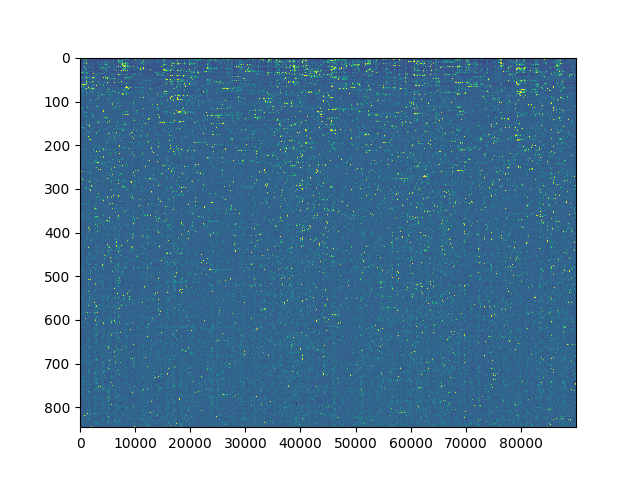

In [29]:
%matplotlib notebook

plt.figure()
# plt.imshow(dFoF_sub_ptile[rmap.isort], aspect='auto', vmax=1)
plt.imshow(
    neural_data_toUse_zscore,
    aspect='auto',
    vmin=-1, 
    vmax=2,
)

In [ ]:
# OLS Regression
theta, factors_temporal_regression, bias = linear_regression.OLS(neural_data_toUse_zscore.T, factors_temporal_nmf_zscore.T)
factors_temporal_regression = factors_temporal_regression.T

In [348]:
# # Ridge Regression
# theta, factors_temporal_regression, bias = linear_regression.Ridge(neural_data_toUse_zscore.T, factors_temporal_nmf_zscore.T, lam=100000)
# factors_temporal_regression = factors_temporal_regression.T

In [349]:
# # ElasticNet Regression
# elr = sklearn.linear_model.ElasticNet(
#     alpha=0.1,
#     l1_ratio=0.05, 
#     fit_intercept=False,
# #     normalize='deprecated',
# #     precompute=False,
#     max_iter=1000, 
# #     copy_X=True, 
#     tol=0.0001,
# #     warm_start=False, 
#     positive=False,
#     random_state=42, 
#     selection='cyclic',
# #     verbose=True,
# )
# elr.fit(neural_data_toUse_zscore.T, factors_temporal_nmf_zscore.T)

# theta = elr.coef_.T
# factors_temporal_regression = elr.predict(neural_data_toUse_zscore.T).T

<IPython.core.display.Javascript object>


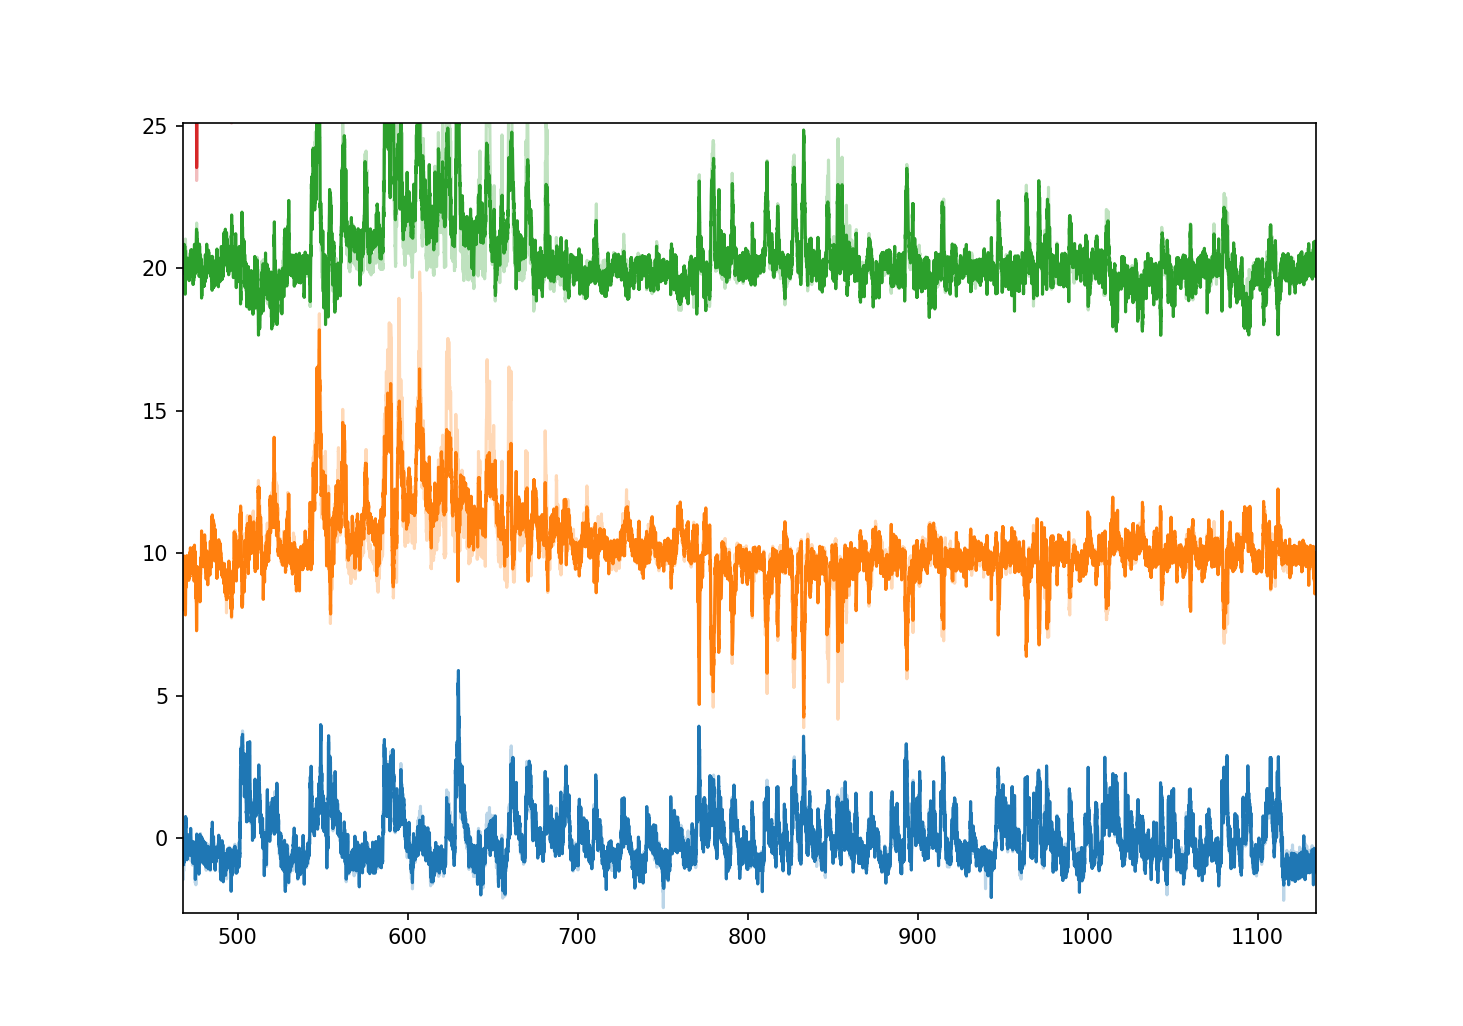

In [141]:
plt.figure()
plt.plot(np.arange(factors_temporal_nmf_zscore.shape[1])/Fs,  factors_temporal_nmf_zscore.T + 10*np.arange(rank)[None,:], alpha=0.3);
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_regression.shape[1])/Fs,  factors_temporal_regression.T + 10*np.arange(rank)[None,:]);

In [133]:
similarity.EV(factors_temporal_nmf_zscore.T, factors_temporal_regression.T)

(array([0.96639769, 0.86247888, 0.82156795, 0.90929369, 0.70712435,
        0.95452663, 0.80180835, 0.89793946, 0.83689289, 0.8772846 ]),
 0.8635314490621663,
 0.8635314490621664)

In [142]:
# Filter based on Explained Variance
# If we can't predict a factor well, don't keep it
ev_threshold = 0.7
_, pairwise, evr_weighted, _ = similarity.pairwise_orthogonalization(factors_temporal_regression.T.astype(np.float32), factors_temporal_nmf_zscore.T.astype(np.float32))
factors_temporal_tokeep = factors_temporal_regression[pairwise > ev_threshold]

rank_good = (pairwise > ev_threshold).sum()
print(f'Rank above 0.7 EV: {rank_good}')

Rank above 0.7 EV: 10


In [143]:
pairwise

array([0.9663983 , 0.86247754, 0.82156646, 0.9092938 , 0.7071259 ,
       0.9545263 , 0.80180764, 0.89793843, 0.836893  , 0.87728435],
      dtype=float32)

#### Loading previous temporal factors?

In [25]:
import numpy as np

In [26]:
# data = np.load(r'D:/RH_local/data/BMI_cage_1511_4/mouse_1511L/20230111/analysis_data/weights_day0.npy', allow_pickle=True)[()]
data = np.load(r'/n/data1/hms/neurobio/sabatini/gyu/data_done/mouse_1511L/20230111/analysis_data/weights_day0.npy', allow_pickle=True)[()]

In [27]:
factors_temporal_tokeep = data['factors_temporal']

In [28]:
rank_good=6

Don't run this for new data!

In [29]:
_, _, evrs = get_highest_evr_var(neural_data_toUse[:,indices_to_use].cpu().numpy().T, factors_temporal_tokeep,  np.ones(rank_good, bool))

In [30]:
evrs

array([0.00446635, 0.005566  , 0.00864774, 0.00585383, 0.00313365,
       0.00414443])

<IPython.core.display.Javascript object>


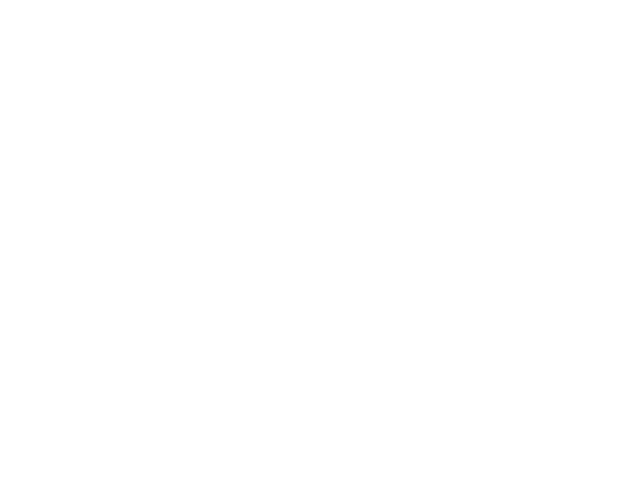

NameError: name 'factors_temporal_nmf_zscore' is not defined

In [31]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs,  factors_temporal_nmf_zscore[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs,  factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good));

In [32]:
weights = theta[:,np.argsort(evrs)[::-1]]
# weights = theta
sf_weights = np.einsum('ij,ikl->jkl', weights,sf[iscell])

%matplotlib notebook
display_toggle_image_stack(
    sf_weights, 
    clim=[sf_weights.min(), sf_weights.max()]
)

NameError: name 'theta' is not defined

# Run Orthogonalization

In [33]:
rank_good = 6

In [34]:
factors_orth = copy.deepcopy(factors_temporal_tokeep)
num_factors = rank_good
hits = np.ones(num_factors, bool)
for i in range(num_factors-1):
    ind_to_orthogonalize, factor_to_orthogonalize, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth, hits)
    print(f'Factor at {ind_to_orthogonalize} index explains {evrs[ind_to_orthogonalize]} of the variance in neural data')
    hits[ind_to_orthogonalize] = False
    factors_orth[hits] = np.transpose(orthogonalize_simple(factors_orth[hits].T, factor_to_orthogonalize))

Factor at 2 index explains 0.007050275802612305 of the variance in neural data
Factor at 0 index explains 0.0038266777992248535 of the variance in neural data
Factor at 1 index explains 0.0034668445587158203 of the variance in neural data
Factor at 5 index explains 0.0025388002395629883 of the variance in neural data
Factor at 4 index explains 0.0025346875190734863 of the variance in neural data


In [35]:
factors_orth.shape

(6, 90000)

In [36]:
neural_data_toUse_zscore.shape

(846, 90000)

In [37]:
# Orthogonalize avgVector time trace out from NMF temporal factors
avgVector = np.ones([846,1])
vector_to_orthogonalize = (neural_data_toUse_zscore.T @ avgVector) / (avgVector.T @ avgVector)

factors_orth_avg = orthogonalize_simple(factors_orth.T, vector_to_orthogonalize).T

<IPython.core.display.Javascript object>


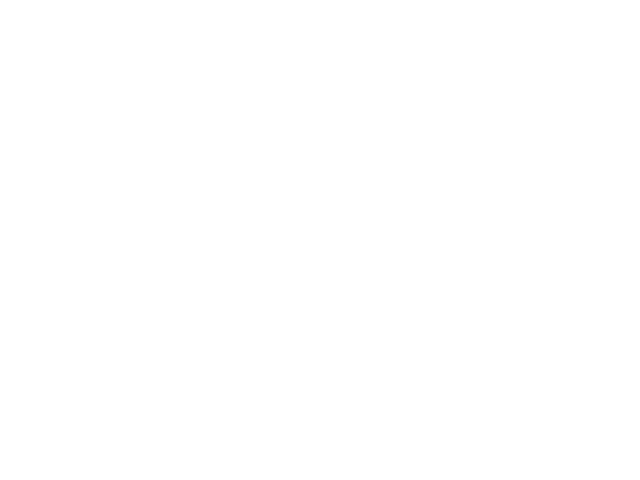

In [38]:
plt.figure()
plt.imshow(np.corrcoef(vector_to_orthogonalize.T, factors_orth))

<IPython.core.display.Javascript object>


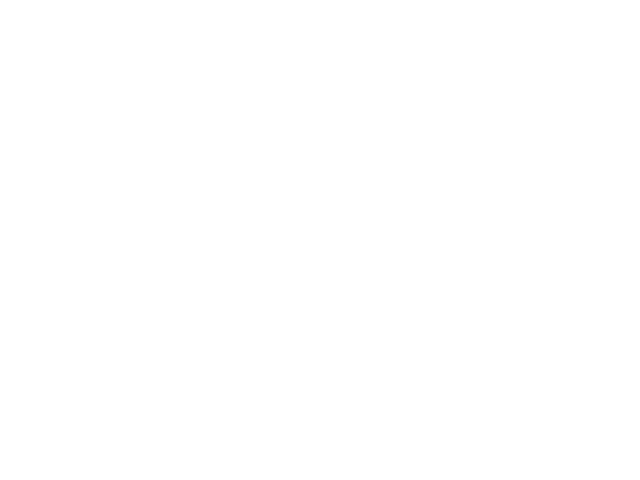

In [39]:
plt.figure()
plt.imshow(np.corrcoef(vector_to_orthogonalize.T, factors_orth_avg))

<IPython.core.display.Javascript object>


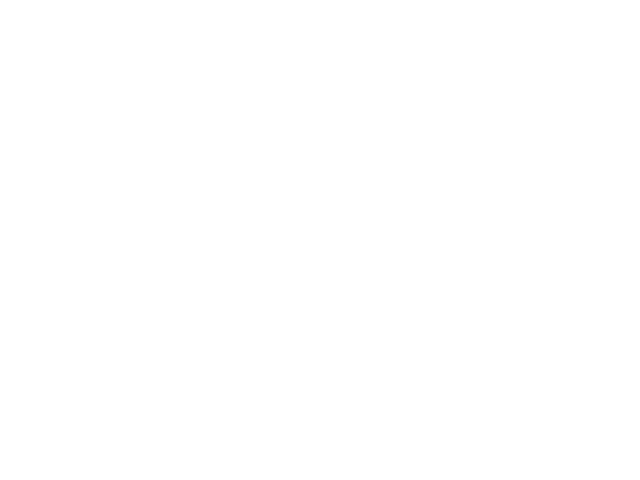

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(factors_temporal_tokeep),vmin=-1)
ax2.imshow(np.corrcoef(factors_orth),vmin=-1)

<IPython.core.display.Javascript object>


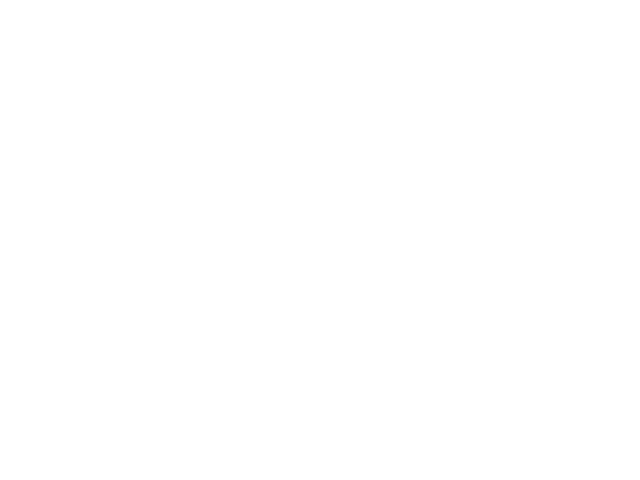

Text(0.5, 0.98, 'Correlation Coefficient of each factors')

In [41]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(factors_orth),vmin=-1)
ax1.set_title("Original NMF factors")
ax2.imshow(np.corrcoef(factors_orth_avg),vmin=-1)
ax2.set_title("NMF factors - avgVectors")
f.suptitle("Correlation Coefficient of each factors", verticalalignment='top')

In [42]:
np.var(factors_orth, axis=1)

array([0.6682409 , 0.50117785, 0.92479724, 0.35752475, 0.6620215 ,
       0.666314  ], dtype=float32)

In [43]:
np.var(factors_orth_avg, axis=1)

array([0.65787254, 0.44948239, 0.88709855, 0.31299483, 0.59083496,
       0.63605942])

In [44]:
ortho_evrs = 1 - (np.var(factors_orth_avg, axis=1) / np.var(factors_orth, axis=1))

<IPython.core.display.Javascript object>


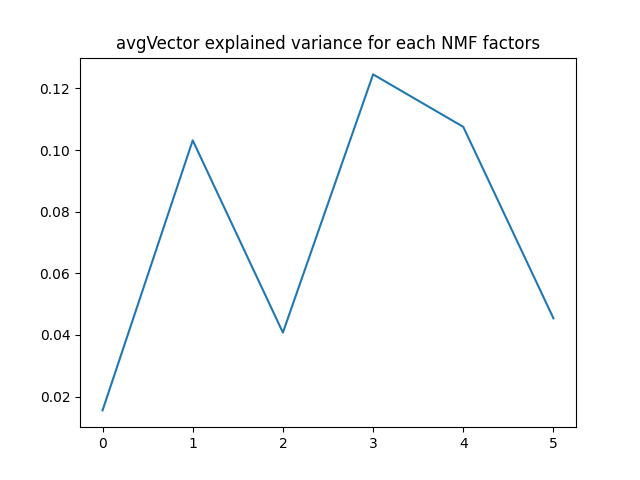

Text(0.5, 1.0, 'avgVector explained variance for each NMF factors')

In [84]:
plt.figure()
plt.plot(ortho_evrs)
plt.title("avgVector explained variance for each NMF factors")

In [116]:
testevr = (factors_orth @ vector_to_orthogonalize) / np.linalg.norm(factors_orth,axis=1)[:,None] / np.linalg.norm(vector_to_orthogonalize)

In [117]:
testevr

array([[0.1277909 ],
       [0.32418784],
       [0.20274993],
       [0.35462719],
       [0.32438696],
       [0.21395955]])

<IPython.core.display.Javascript object>


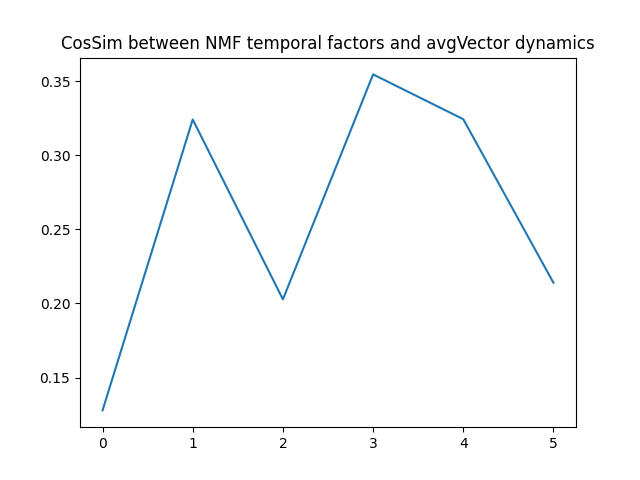

Text(0.5, 1.0, 'CosSim between NMF temporal factors and avgVector dynamics')

In [118]:
plt.figure()
plt.plot(testevr)
plt.title("CosSim between NMF temporal factors and avgVector dynamics")

In [120]:
data['weights_all'].shape

(846, 6)

In [119]:
avgVector.shape

(846, 1)

In [123]:
test_neural = (data['weights_all'].T @ avgVector) / np.linalg.norm(data['weights_all'].T,axis=1)[:,None] / np.linalg.norm(avgVector)

<IPython.core.display.Javascript object>


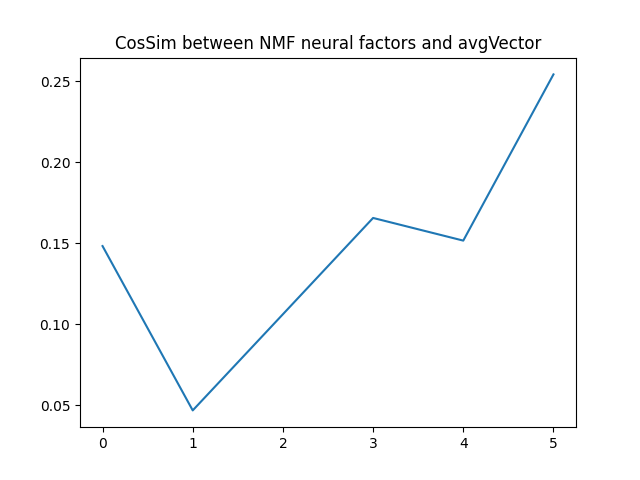

Text(0.5, 1.0, 'CosSim between NMF neural factors and avgVector')

In [124]:
plt.figure()
plt.plot(test_neural)
plt.title("CosSim between NMF neural factors and avgVector")

In [114]:
np.linalg.norm(factors_orth, axis=1).shape

(6,)

In [150]:
_, _, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth,  np.ones(num_factors, bool))

In [151]:
np.sort(evrs)

array([0.00173912, 0.00238311, 0.00257944, 0.00414846, 0.00497818,
       0.00800569, 0.01053058, 0.01284787, 0.02147295, 0.02956192])

# Run Regression Pt 2

In [45]:
# OLS Regression: original NMF temporal factors
theta, factors_orth_regression, bias = linear_regression.OLS(neural_data_toUse_zscore.T, factors_orth.T)
factors_orth_regression = factors_orth_regression.T

In [46]:
_, _, evrs = get_highest_evr_var(neural_data_toUse[:,indices_to_use].cpu().numpy().T, factors_orth,  np.ones(num_factors, bool))
# _, _, evrs = get_highest_evr_var(neural_data_toUse[:,indices_to_use].T, factors_orth,  np.ones(num_factors, bool))

In [47]:
# OLS Regression with avgVector-orthogonalized NMF temporal factors
theta2, factors_orth_regression2, bias = linear_regression.OLS(neural_data_toUse_zscore.T, factors_orth_avg.T)
factors_orth_regression2 = factors_orth_regression2.T

In [48]:
_, _, evrs2 = get_highest_evr_var(neural_data_toUse[:,indices_to_use].cpu().numpy().T, factors_orth_avg,  np.ones(num_factors, bool))

<IPython.core.display.Javascript object>


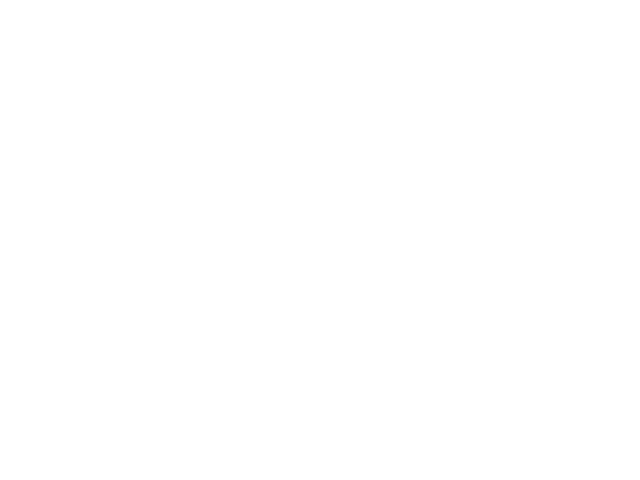

Text(0.5, 0.98, 'Correlation Coefficient of each factors')

In [49]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(theta.T),vmin=-1)
ax2.imshow(np.corrcoef(theta2.T),vmin=-1)
f.suptitle("Correlation Coefficient of each factors", verticalalignment='top')

In [50]:
print(evrs)
print(evrs2)

[0.0046078  0.00369817 0.00864774 0.00247085 0.00266892 0.00283056]
[0.00457476 0.0031627  0.00851859 0.00233012 0.00225398 0.00281068]


In [51]:
evrs_comparison = 1 - (evrs2 / evrs)

<IPython.core.display.Javascript object>


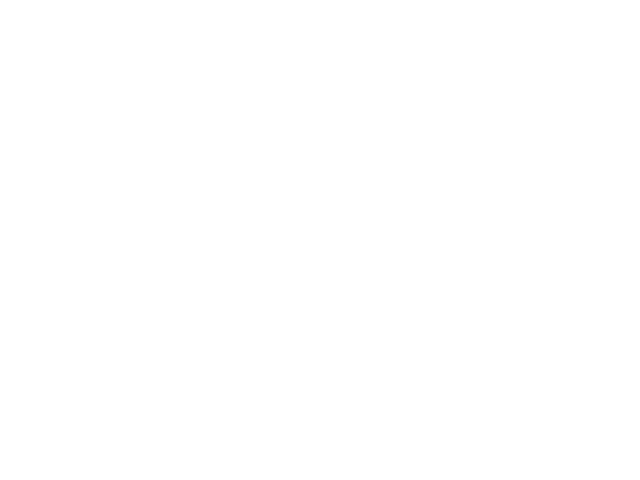

Text(0.5, 1.0, '1 - (factors to neural data evr) / ((factors - avg) to neural data evr)')

In [52]:
plt.figure()
plt.plot(evrs_comparison)
plt.title("1 - (factors to neural data evr) / ((factors - avg) to neural data evr)")

<IPython.core.display.Javascript object>


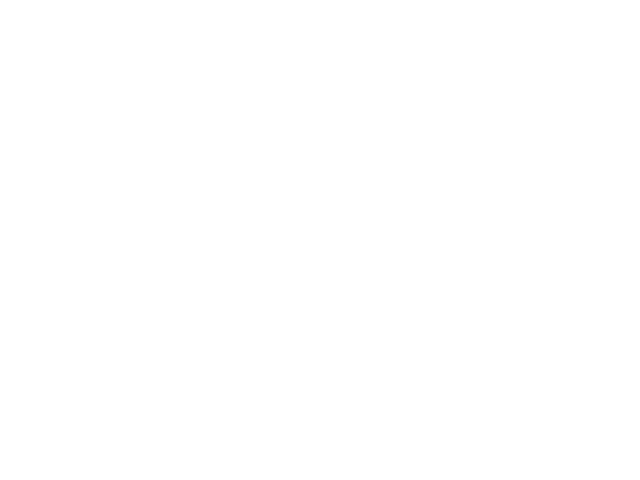

In [53]:
plt.figure()
plt.plot(np.sort(evrs)[::-1])

<IPython.core.display.Javascript object>


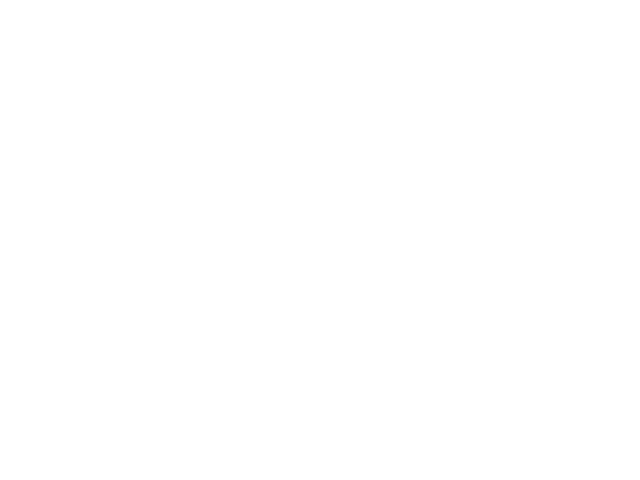

In [54]:
plt.figure()
plt.plot(np.sort(evrs2)[::-1])

# Visualize

<IPython.core.display.Javascript object>


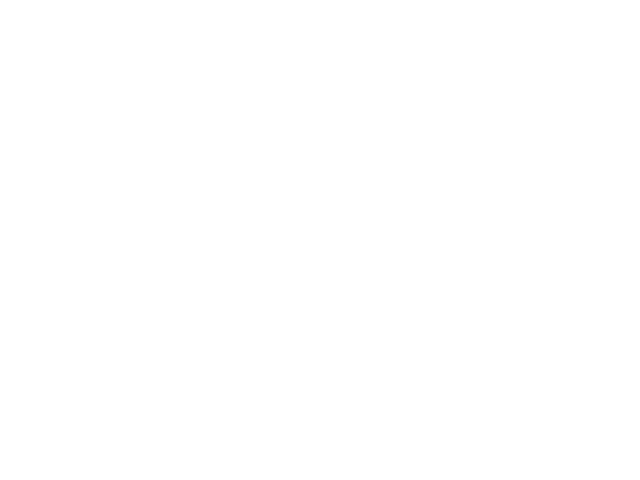

In [55]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good))

<IPython.core.display.Javascript object>


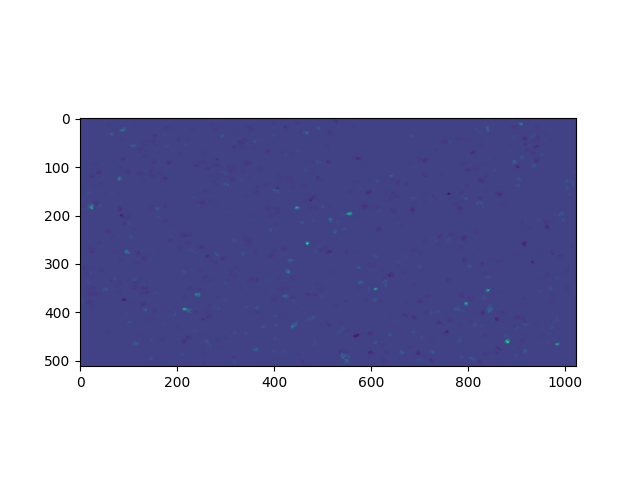

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

In [56]:
weights = theta[:,np.argsort(evrs)[::-1]]
sf_weights = np.einsum('ij,ikl->jkl', weights,sf[iscell])

factors_orth_regression_sorted = factors_orth_regression[np.argsort(evrs)[::-1]]

%matplotlib notebook
display_toggle_image_stack(sf_weights)

In [57]:
weights.shape

(846, 6)

In [58]:
weights.mean(0)

array([0.00196319, 0.00074565, 0.00163307, 0.00309633, 0.00311177,
       0.00386457], dtype=float32)

In [59]:
weights_zeroSum = weights - weights.mean(0)

In [60]:
weights_zeroSum.sum(0)

array([ 0.0000000e+00,  8.9406967e-08,  1.1920929e-07,  3.6507845e-07,
       -1.7881393e-07, -5.3644180e-07], dtype=float32)

In [61]:
avgVector.shape

(846, 1)

In [108]:
(weights * avgVector).sum(0)

array([2.63255783, 3.26942838, 2.61949136, 1.66085984, 1.38158093,
       0.63081629])

<IPython.core.display.Javascript object>


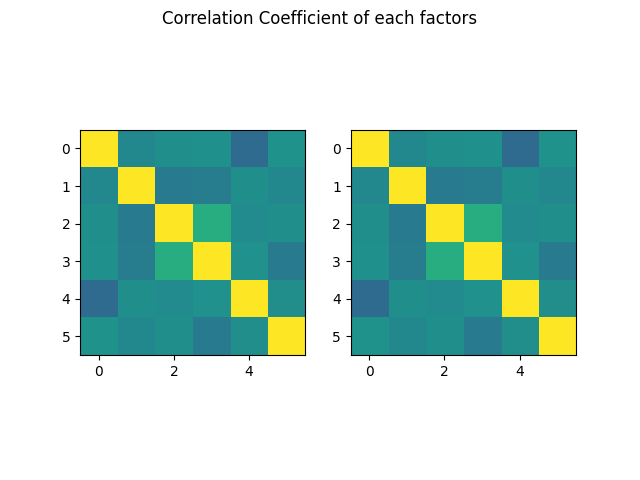

Text(0.5, 0.98, 'Correlation Coefficient of each factors')

In [102]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(weights.T),vmin=-1)
ax2.imshow(np.corrcoef(weights_zeroSum.T),vmin=-1)
f.suptitle("Correlation Coefficient of each factors", verticalalignment='top')

<IPython.core.display.Javascript object>


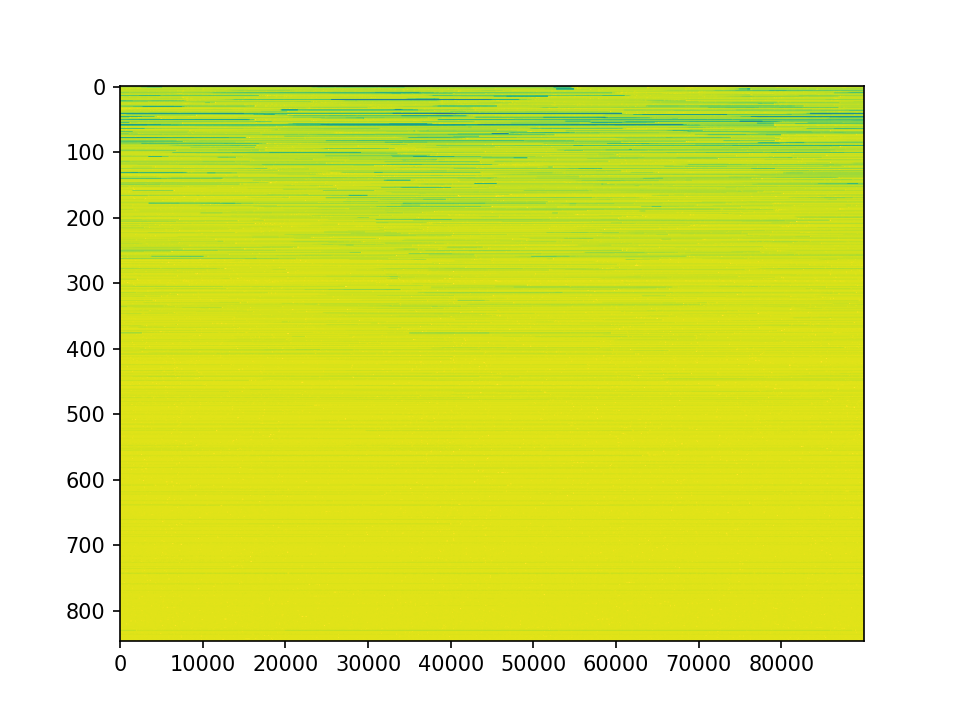

In [166]:
plt.figure()
plt.imshow(neural_data_toUse_zscore, aspect='auto', vmax=4)

<IPython.core.display.Javascript object>


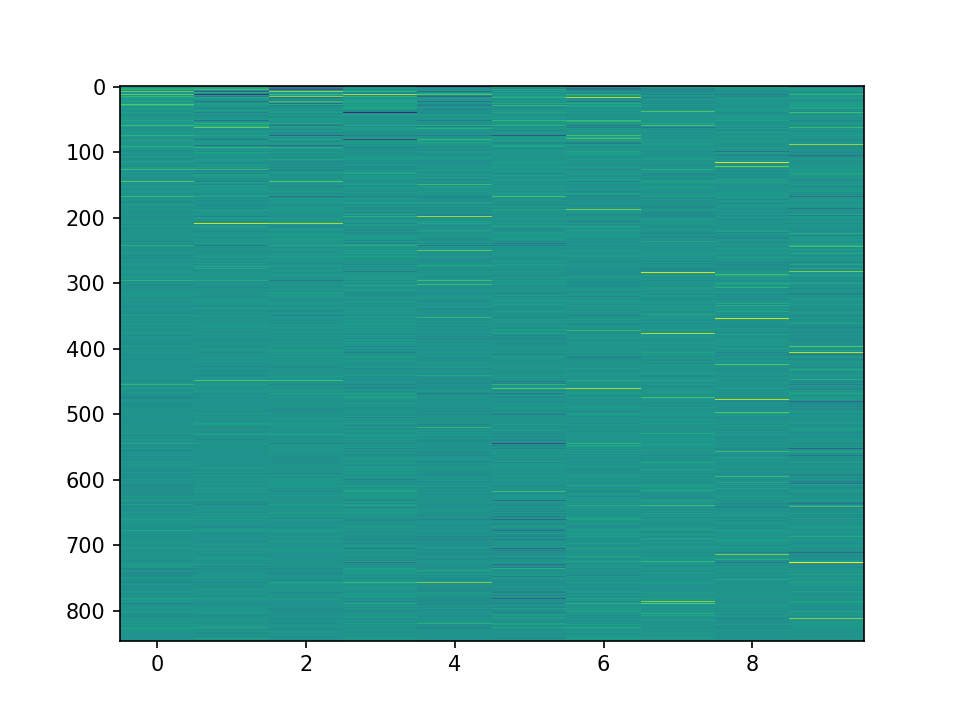

In [167]:
%matplotlib notebook
plt.figure()
plt.imshow(theta[:,:],aspect='auto', interpolation='none')

<IPython.core.display.Javascript object>


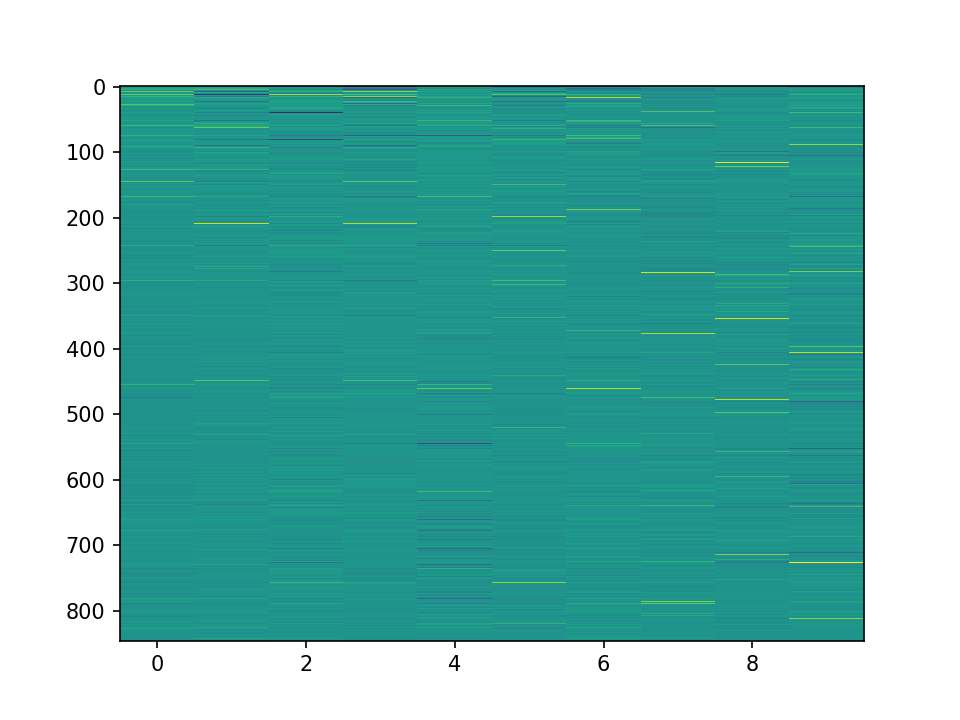

In [168]:
%matplotlib notebook
plt.figure()
plt.imshow(weights_zeroSum[:,:],aspect='auto', interpolation='none')

visualization of final traces and masks

### Manipold comparison: Original neural factor vs. post-ortho. neural factor manifold

In [63]:
weights_ori = data['weights_all']
weights_ortho = theta2 - theta2.mean(0) # zero_sum

In [64]:
weights_ortho.sum(0)

array([-1.56125113e-16, -7.96238075e-16,  1.43288159e-15, -7.56773116e-16,
       -2.71657696e-15,  9.54097912e-17])

<IPython.core.display.Javascript object>


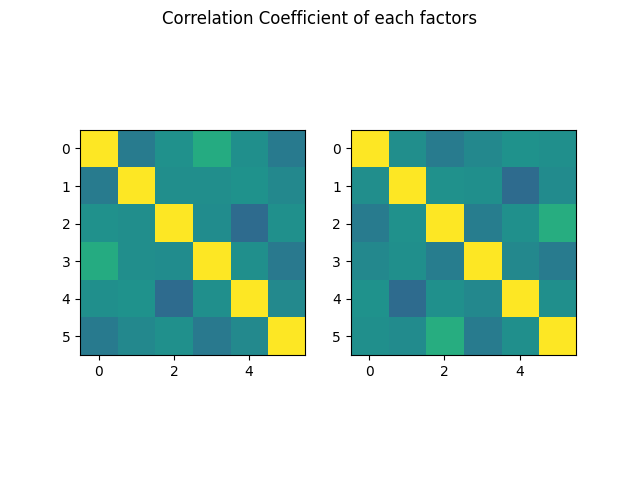

Text(0.5, 0.98, 'Correlation Coefficient of each factors')

In [65]:
# Check neural factor orthogonality
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(weights_ori.T),vmin=-1)
ax2.imshow(np.corrcoef(weights_ortho.T),vmin=-1)
f.suptitle("Correlation Coefficient of each factors", verticalalignment='top')

In [69]:
import scipy

In [72]:
basis_ori = scipy.linalg.orth(weights_ori)
basis_ortho = scipy.linalg.orth(weights_ortho)

In [74]:
print(basis_ori.shape)
print(basis_ortho.shape)

(846, 6)
(846, 6)


<IPython.core.display.Javascript object>


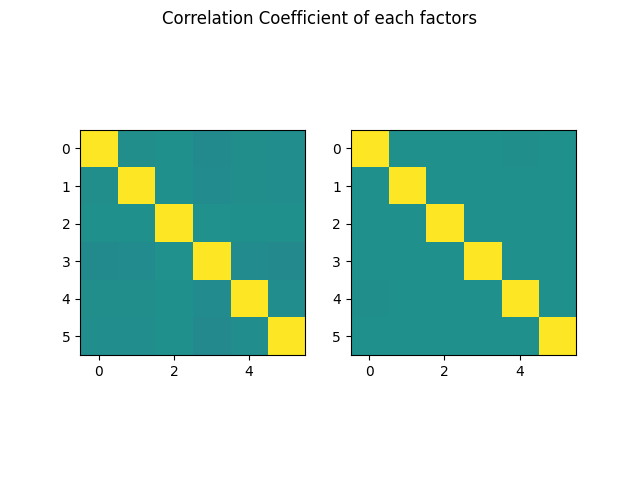

Text(0.5, 0.98, 'Correlation Coefficient of each factors')

In [73]:
# Check neural factor orthogonality
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(basis_ori.T),vmin=-1)
ax2.imshow(np.corrcoef(basis_ortho.T),vmin=-1)
f.suptitle("Correlation Coefficient of each factors", verticalalignment='top')

In [86]:
tester = basis_ortho @ basis_ortho.T @ weights_ori @ weights_ori.T @ basis_ortho @ basis_ortho.T

In [87]:
np.trace(tester)

1.3113896084995693

In [88]:
tester2 = basis_ortho @ basis_ortho.T @ weights_ori @ weights_ori.T

In [89]:
np.trace(tester2)

1.3113896084995678

In [90]:
tester3 = weights_ori.T @ basis_ortho @ basis_ortho.T @ weights_ori

In [91]:
np.trace(tester3)

1.3113896084995682

In [100]:
def manifold_similarity(M1, M2_basis):
    numerator = np.trace(M1.T @ M2_basis @ M2_basis.T @ M1)
    denominator = np.trace(M1 @ M1.T)
    return numerator / denominator

In [101]:
manifold_similarity(weights_ori, basis_ortho)

0.9662438309203891

In [97]:
manifold_similarity(basis_ori, basis_ortho)

0.9601970478994111

In [99]:
manifold_similarity2(basis_ori, basis_ortho)

0.9601970478994103

In [83]:
basis_ortho @ basis_ortho.T

array([[ 0.08420611,  0.00071881,  0.01351984, ..., -0.00219811,
        -0.00488711, -0.00484079],
       [ 0.00071881,  0.00073558,  0.00119993, ...,  0.00109694,
         0.00122231,  0.00175673],
       [ 0.01351984,  0.00119993,  0.00738039, ...,  0.00614079,
        -0.00273926,  0.00072764],
       ...,
       [-0.00219811,  0.00109694,  0.00614079, ...,  0.01515119,
        -0.00210518,  0.00106441],
       [-0.00488711,  0.00122231, -0.00273926, ..., -0.00210518,
         0.006713  ,  0.00469524],
       [-0.00484079,  0.00175673,  0.00072764, ...,  0.00106441,
         0.00469524,  0.00624332]])

# Save it all

In [371]:
factor_to_use = 0 # 0-indexed
weights = theta[:,np.argsort(evrs)[::-1]]

weights_day0 = {
    "weights": weights[:,factor_to_use],
    "weights_all" : weights,
    "iscell_custom": iscell,
    "factor_to_use": factor_to_use,
    "sf_weights": sf_weights,
#     "factors_temporal": factors_temporal_tokeep,
    "factors_temporal": factors_orth_regression_sorted,
}


F = scipy.io.savemat(path_save.with_suffix('.mat') , weights_day0)

np.save(path_save.with_suffix('.npy') , weights_day0)

# Load in old outputs

In [2]:
import numpy as np

In [2]:
data = np.load(r'D:/RH_local/data/BMI_cage_1511_4/mouse_1511L/20230111/analysis_data/weights_day0.npy', allow_pickle=True)[()]

In [3]:
data = np.load(r'/n/data1/hms/neurobio/sabatini/gyu/data_done/mouse_1511L/20230111/analysis_data/weights_day0.npy', allow_pickle=True)[()]

In [11]:
data.keys()

dict_keys(['weights', 'weights_all', 'iscell_custom', 'factor_to_use', 'sf_weights', 'factors_temporal'])

In [5]:
import bnpm.plotting_helpers

<IPython.core.display.Javascript object>


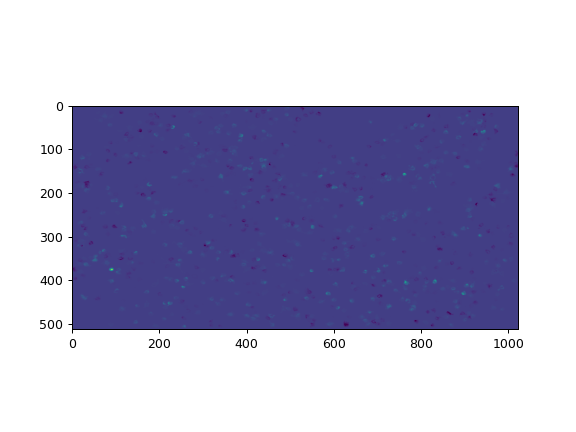

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

In [17]:
# weights = theta[:,np.argsort(evrs)[::-1]]
# sf_weights = np.einsum('ij,ikl->jkl', data['weights_all'], sf[data['iscell_custom']])

%matplotlib notebook
bnpm.plotting_helpers.display_toggle_image_stack(data['sf_weights'])

In [ ]:
components , scores , explained_variance_ratio_ , stds = decomposition.simple_pca(neural_data_toUse.T.cpu().numpy() , n_components=None , mean_sub=True, zscore=False, plot_pref=True , n_PCs_toPlot=2)

In [ ]:
factors_orth_regression.shape

In [6]:
Fs = 30

In [7]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


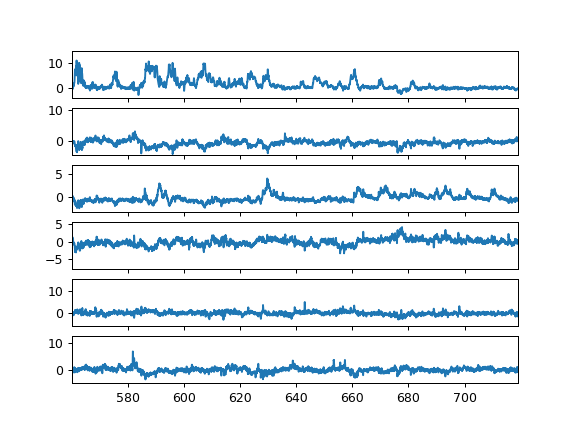

In [18]:
%matplotlib notebook
fig, axs = plt.subplots(data['factors_temporal'].shape[0], 1, sharex=True)
for ii in range(axs.shape[0]):
#     axs[ii,0].plot(np.arange(data['factors_temporal'].shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[-ii-1],:].T)
    axs[ii].plot(np.arange(data['factors_temporal'].shape[1])/Fs, data['factors_temporal'][ii])

<IPython.core.display.Javascript object>


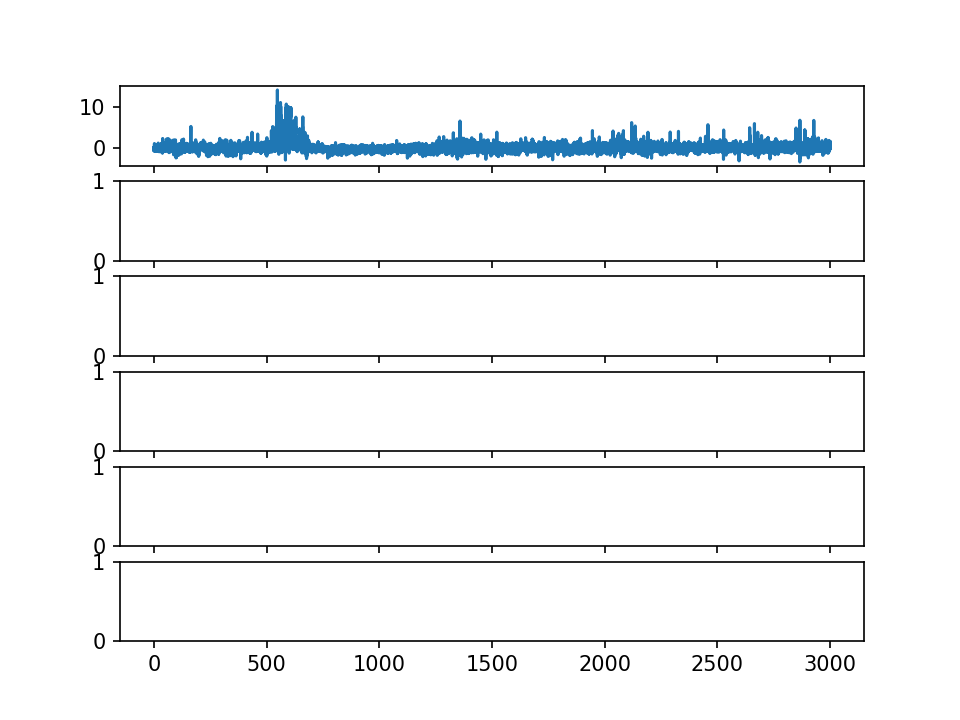

In [9]:
fig, axs = plt.subplots(data['factors_temporal'].shape[0], 1, sharex=True)
axs[0].plot(np.arange(data['factors_temporal'].shape[1])/Fs, data['factors_temporal'][0])

<IPython.core.display.Javascript object>


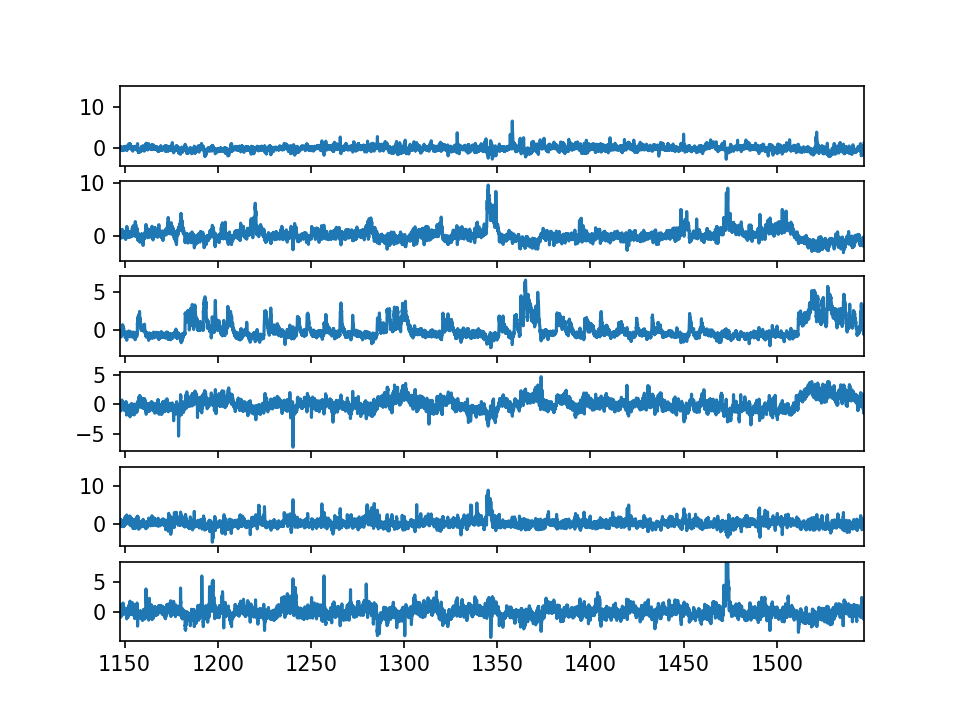

In [8]:
%matplotlib notebook
fig, axs = plt.subplots(data['factors_temporal'].shape[0], 1, sharex=True)
for ii in range(axs.shape[0]):
#     axs[ii,0].plot(np.arange(data['factors_temporal'].shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[-ii-1],:].T)
    axs[ii].plot(np.arange(data['factors_temporal'].shape[1])/Fs, data['factors_temporal'][ii])

<IPython.core.display.Javascript object>


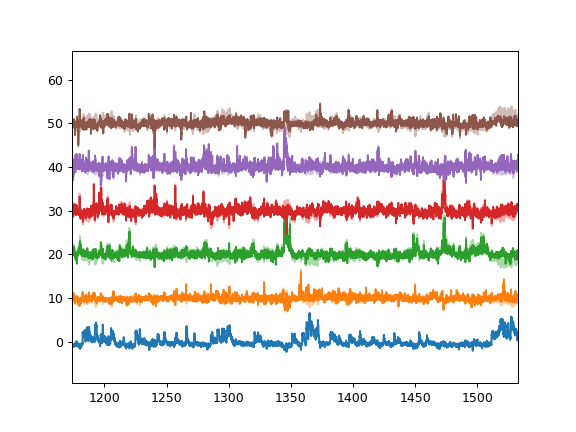

In [372]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good))

In [ ]:
import rastermap

In [ ]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
#     nPC=200,
#     init='pca',
#     alpha=1.0,
#     K=1.0,
#     mode='basic',
#     verbose=True,
#     annealing=True,
#     constraints=2,
)

In [ ]:
# embedding = rmap.fit_transform(neural_data_toUse.cpu().numpy())
# embedding = rmap.fit_transform(dFoF)
embedding = rmap.fit_transform(np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression]))

In [ ]:
plt.figure()
plt.hist(embedding, 400);
plt.hist(embedding[-10:], 100);

In [ ]:
plt.figure()
plt.imshow(
#     timeSeries.scale_between(neural_data_toUse.cpu().numpy()[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     timeSeries.scale_between(spks_s2p[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     dFoF[rmap.isort], vmax=5, 
    np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression])[rmap.isort], 
    vmin=0,
    vmax=5, 
    aspect='auto',
#     extent=[0, indices_to_use.max()/Fs, 0, neural_data_toUse.shape[0]]
)
plt.xticks(ticks=np.arange(0,factors_temporal_tokeep.shape[1], 10000), labels=np.round(np.arange(0,factors_temporal_tokeep.shape[1], 10000)/Fs))

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
ax1.imshow(
#     timeSeries.scale_between(neural_data_toUse.cpu().numpy()[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     timeSeries.scale_between(spks_s2p[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     dFoF[rmap.isort], vmax=5, 
    np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression])[rmap.isort], 
    vmin=0,
    vmax=5, 
    aspect='auto',
#     extent=[0, indices_to_use.max()/Fs, 0, neural_data_toUse.shape[0]]
)
#ax1.set_xticks(ticks=np.arange(0,factors_temporal_tokeep.shape[1], 10000), labels=np.round(np.arange(0,factors_temporal_tokeep.shape[1], 10000)/Fs))
ax2.plot(factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(10),alpha=0.4)
ax2.plot(factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(10))

In [ ]:
indices_to_use.shape

# Simulate and get threshold_crossing moment

In [53]:
import natsort

In [54]:
root_logger = Path("/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/").resolve()
dir_logger_valsROIs = []
for path_object in root_logger.rglob('*'):
    if "logger_valsROIs.mat" in str(path_object):
        dir_logger_valsROIs.append(path_object)
        
dir_logger_valsROIs = natsort.natsorted(dir_logger_valsROIs)
dir_logger_valsROIs

[PosixPath('/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230112/analysis_data/logger_valsROIs.mat'),
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230113/analysis_data/logger_valsROIs.mat'),
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230114/analysis_data/logger_valsROIs.mat'),
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230115/analysis_data/logger_valsROIs.mat'),
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230116/analysis_data/logger_valsROIs.mat'),
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230117/analysis_data/logger_valsROIs.mat'),
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230118/analysis_data/logger_valsROIs.mat'),
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230119/analysis_data/logger_valsROIs.mat'),
 PosixPath('/n/data1/hms/neurobio/sabati

In [72]:
decoder_ori.sum()

1.66086

In [70]:
weights_ortho.sum(0)

array([-5.55111512e-16, -6.93889390e-17,  2.22044605e-16, -2.28983499e-16,
       -1.11022302e-16,  0.00000000e+00])

In [118]:
vals_neurons_zscore_all = []
for date in dir_logger_valsROIs:
    # Where am I?
    print(date)
    
    # Load online vals_neurons value
    vals_neurons = scipy.io.loadmat(date)['logger_valsROIs']
    
    # Remove NaN timepoints to correctly calculate moving Z-score
    vals_neurons_clean = vals_neurons[~np.isnan(vals_neurons).any(axis=1)]
    vals_neurons_zscore = welford_moving_2D.make_rollingZScore(vals_neurons_clean, win_roll=int(Fs*60*15))
    vals_neurons_zscore = np.nan_to_num(vals_neurons_zscore)
    vals_neurons_zscore_all.append(vals_neurons_zscore)

/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230112/analysis_data/logger_valsROIs.mat


100%|██████████| 104914/104914 [00:13<00:00, 7545.86it/s]
/n/data1/hms/neurobio/sabatini/gyu/github_clone/basic_neural_processing_modules/bnpm/welford_moving_2D.py:142: RuntimeWarning: invalid value encountered in divide
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230113/analysis_data/logger_valsROIs.mat


100%|██████████| 104900/104900 [00:14<00:00, 7426.37it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230114/analysis_data/logger_valsROIs.mat


100%|██████████| 104880/104880 [00:13<00:00, 7805.93it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230115/analysis_data/logger_valsROIs.mat


100%|██████████| 104894/104894 [00:13<00:00, 7779.03it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230116/analysis_data/logger_valsROIs.mat


100%|██████████| 104902/104902 [00:13<00:00, 7650.88it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230117/analysis_data/logger_valsROIs.mat


100%|██████████| 104915/104915 [00:13<00:00, 7793.81it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230118/analysis_data/logger_valsROIs.mat


100%|██████████| 104854/104854 [00:14<00:00, 7274.25it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230119/analysis_data/logger_valsROIs.mat


100%|██████████| 104440/104440 [00:13<00:00, 7800.12it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230120/analysis_data/logger_valsROIs.mat


100%|██████████| 90441/90441 [00:12<00:00, 7346.72it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230121/analysis_data/logger_valsROIs.mat


100%|██████████| 104950/104950 [00:13<00:00, 7756.53it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230122/analysis_data/logger_valsROIs.mat


100%|██████████| 104845/104845 [00:13<00:00, 7791.86it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230123/analysis_data/logger_valsROIs.mat


100%|██████████| 104911/104911 [00:14<00:00, 7373.59it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230124/analysis_data/logger_valsROIs.mat


100%|██████████| 85039/85039 [00:10<00:00, 7840.99it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230125/analysis_data/logger_valsROIs.mat


100%|██████████| 82244/82244 [00:10<00:00, 7533.63it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230126/analysis_data/logger_valsROIs.mat


100%|██████████| 104840/104840 [00:13<00:00, 7586.41it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230127/analysis_data/logger_valsROIs.mat


100%|██████████| 104882/104882 [00:13<00:00, 7609.60it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230128/analysis_data/logger_valsROIs.mat


100%|██████████| 104947/104947 [00:13<00:00, 7598.24it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230129/analysis_data/logger_valsROIs.mat


100%|██████████| 104931/104931 [00:13<00:00, 7659.47it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230130/analysis_data/logger_valsROIs.mat


100%|██████████| 104915/104915 [00:14<00:00, 7438.51it/s]


In [93]:
# Load weight values: original factors OR avgVector-orthogonalized factors
weights = data['weights_all']
weights_ortho = theta2[:,np.argsort(evrs)[::-1]]

# Zero-sum weights_ortho
weights_ortho = weights_ortho - weights_ortho.mean(0)

# First Factor
decoder_ori = weights[:,0][:,None]
decoder_ortho = weights_ortho[:,0][:,None]

cursor_zscore_ori_all, cursor_zscore_ortho_all = [], []

for date in dir_logger_valsROIs:
    # Where am I?
    print(date)
    
    # Load online vals_neurons value
    vals_neurons = scipy.io.loadmat(date)['logger_valsROIs']
    
    # Remove NaN timepoints to correctly calculate moving Z-score
    vals_neurons_clean = vals_neurons[~np.isnan(vals_neurons).any(axis=1)]
    vals_neurons_zscore = welford_moving_2D.make_rollingZScore(vals_neurons_clean, win_roll=int(Fs*60*15))
    vals_neurons_zscore = np.nan_to_num(vals_neurons_zscore)
    
    # Calculate Raw Cursor timeseries
    raw_cursor_ori = vals_neurons_zscore @ decoder_ori
    raw_cursor_ortho = vals_neurons_zscore @ decoder_ortho
    
    # Z-score cursor
    cursor_zscore_ori = welford_moving_2D.make_rollingZScore(raw_cursor_ori, win_roll=int(Fs*60*15))
    cursor_zscore_ortho = welford_moving_2D.make_rollingZScore(raw_cursor_ortho, win_roll=int(Fs*60*15))
    
    # Append
    cursor_zscore_ori_all.append(cursor_zscore_ori)
    cursor_zscore_ortho_all.append(cursor_zscore_ortho)

/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230112/analysis_data/logger_valsROIs.mat


100%|██████████| 104914/104914 [00:03<00:00, 28035.30it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230113/analysis_data/logger_valsROIs.mat


100%|██████████| 104900/104900 [00:03<00:00, 31881.40it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230114/analysis_data/logger_valsROIs.mat


100%|██████████| 104880/104880 [00:03<00:00, 29418.06it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230115/analysis_data/logger_valsROIs.mat


100%|██████████| 104894/104894 [00:03<00:00, 29192.77it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230116/analysis_data/logger_valsROIs.mat


100%|██████████| 104902/104902 [00:03<00:00, 26475.32it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230117/analysis_data/logger_valsROIs.mat


100%|██████████| 104915/104915 [00:03<00:00, 31335.82it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230118/analysis_data/logger_valsROIs.mat


100%|██████████| 104854/104854 [00:03<00:00, 28214.76it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230119/analysis_data/logger_valsROIs.mat


100%|██████████| 104440/104440 [00:03<00:00, 30437.65it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230120/analysis_data/logger_valsROIs.mat


100%|██████████| 90441/90441 [00:03<00:00, 27015.27it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230121/analysis_data/logger_valsROIs.mat


100%|██████████| 104950/104950 [00:03<00:00, 29227.09it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230122/analysis_data/logger_valsROIs.mat


100%|██████████| 104845/104845 [00:03<00:00, 27256.51it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230123/analysis_data/logger_valsROIs.mat


100%|██████████| 104911/104911 [00:03<00:00, 30377.15it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230124/analysis_data/logger_valsROIs.mat


100%|██████████| 85039/85039 [00:02<00:00, 28692.28it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230125/analysis_data/logger_valsROIs.mat


100%|██████████| 82244/82244 [00:03<00:00, 25704.41it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230126/analysis_data/logger_valsROIs.mat


100%|██████████| 104840/104840 [00:03<00:00, 27938.13it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230127/analysis_data/logger_valsROIs.mat


100%|██████████| 104882/104882 [00:03<00:00, 30955.67it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230128/analysis_data/logger_valsROIs.mat


100%|██████████| 104947/104947 [00:03<00:00, 28820.79it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230129/analysis_data/logger_valsROIs.mat


100%|██████████| 104931/104931 [00:03<00:00, 29301.60it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230130/analysis_data/logger_valsROIs.mat


100%|██████████| 104915/104915 [00:04<00:00, 26040.17it/s]


<IPython.core.display.Javascript object>


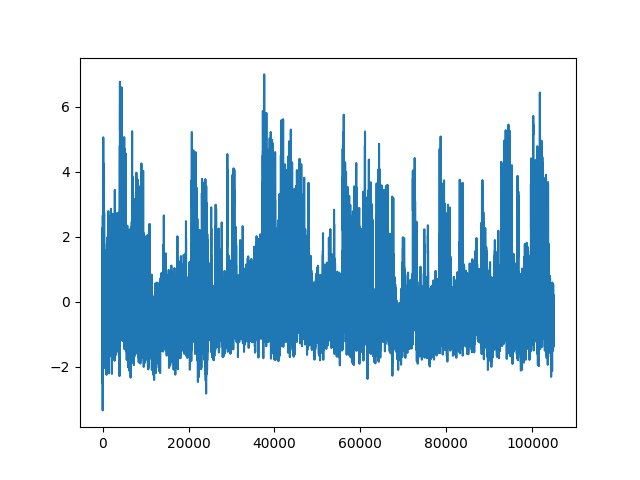

In [356]:
plt.figure()
plt.plot(cursor_zscore_ori_all[0])

In [96]:
# Cursor simulation
def simple_cursor_simulation(cursor, threshold):
    crossing_moment = []
    num_reward = 0
    CE_trial = 1
    quiescence_hold = 30 * 0.5
    quiescence_count = 0
    
    for ii, cursor_val in tqdm(enumerate(cursor)):
        if CE_trial:
            if cursor_val > threshold:
                CE_trial = 0
                num_reward += 1
                crossing_moment.append(ii)
        else:
            if cursor_val < 0:
                quiescence_count += 1
            else:
                quiescence_count = 0
            if quiescence_count > quiescence_hold:
                CE_trial = 1
                quiescence_count = 0  
                
    return num_reward, crossing_moment

In [105]:
# Cursor simulation
threshold = 2
num_reward_all, num_reward_ortho_all = [], []
crossing_moment_all, crossing_moment_ortho_all = [], []

for cursor_zscore in cursor_zscore_ori_all:
    num_reward, crossing_moment = simple_cursor_simulation(cursor_zscore[3600:], threshold)
    crossing_moment = np.array(crossing_moment) + 3600
    crossing_moment_all.append(crossing_moment)
    num_reward_all.append(num_reward)
    
for cursor_zscore in cursor_zscore_ortho_all:
    num_reward, crossing_moment_ortho = simple_cursor_simulation(cursor_zscore[3600:], threshold)
    num_reward_ortho_all.append(num_reward)
    crossing_moment_ortho = np.array(crossing_moment_ortho) + 3600
    crossing_moment_ortho_all.append(crossing_moment_ortho)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

<IPython.core.display.Javascript object>


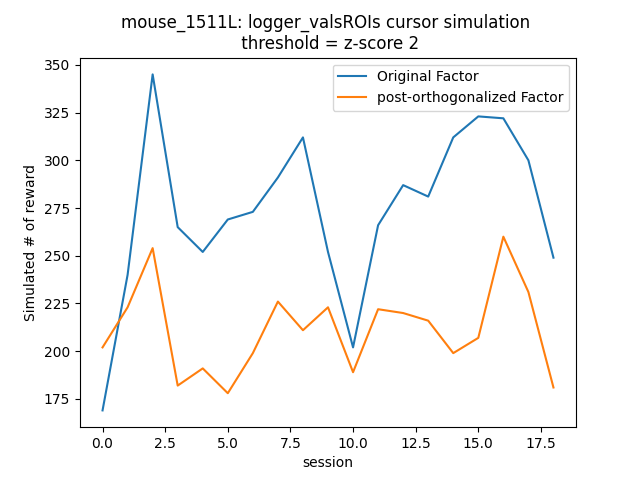

Text(0.5, 1.0, 'mouse_1511L: logger_valsROIs cursor simulation \n threshold = z-score 2')

In [98]:
plt.figure()
plt.plot(num_reward_all, label="Original Factor")
plt.plot(num_reward_ortho_all, label="post-orthogonalized Factor")
plt.legend()
plt.xlabel("session")
plt.ylabel("Simulated # of reward")
plt.title("mouse_1511L: logger_valsROIs cursor simulation \n threshold = z-score 2")

In [83]:
decoder_avg = np.ones([846,1])

cursor_zscore_avg_all = []

for date in dir_logger_valsROIs:
    # Where am I?
    print(date)
    
    # Load online vals_neurons value
    vals_neurons = scipy.io.loadmat(date)['logger_valsROIs']
    
    # Remove NaN timepoints to correctly calculate moving Z-score
    vals_neurons_clean = vals_neurons[~np.isnan(vals_neurons).any(axis=1)]
    vals_neurons_zscore = welford_moving_2D.make_rollingZScore(vals_neurons_clean, win_roll=int(Fs*60*15))
    vals_neurons_zscore = np.nan_to_num(vals_neurons_zscore)
    
    # Calculate Raw Cursor timeseries
    raw_cursor_avg = vals_neurons_zscore @ decoder_avg
    
    # Z-score cursor
    cursor_zscore_avg = welford_moving_2D.make_rollingZScore(raw_cursor_avg, win_roll=int(Fs*60*15))
    
    # Append
    cursor_zscore_avg_all.append(cursor_zscore_avg)

/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230112/analysis_data/logger_valsROIs.mat


100%|██████████| 104914/104914 [00:03<00:00, 29941.00it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230113/analysis_data/logger_valsROIs.mat


100%|██████████| 104900/104900 [00:03<00:00, 28527.67it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230114/analysis_data/logger_valsROIs.mat


100%|██████████| 104880/104880 [00:03<00:00, 27205.29it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230115/analysis_data/logger_valsROIs.mat


100%|██████████| 104894/104894 [00:03<00:00, 26239.75it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230116/analysis_data/logger_valsROIs.mat


100%|██████████| 104902/104902 [00:03<00:00, 28623.33it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230117/analysis_data/logger_valsROIs.mat


100%|██████████| 104915/104915 [00:03<00:00, 28047.26it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230118/analysis_data/logger_valsROIs.mat


100%|██████████| 104854/104854 [00:03<00:00, 27478.24it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230119/analysis_data/logger_valsROIs.mat


100%|██████████| 104440/104440 [00:03<00:00, 30828.65it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230120/analysis_data/logger_valsROIs.mat


100%|██████████| 90441/90441 [00:02<00:00, 30726.89it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230121/analysis_data/logger_valsROIs.mat


100%|██████████| 104950/104950 [00:03<00:00, 27550.21it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230122/analysis_data/logger_valsROIs.mat


100%|██████████| 104845/104845 [00:03<00:00, 30341.82it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230123/analysis_data/logger_valsROIs.mat


100%|██████████| 104911/104911 [00:03<00:00, 30572.07it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230124/analysis_data/logger_valsROIs.mat


100%|██████████| 85039/85039 [00:02<00:00, 31857.23it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230125/analysis_data/logger_valsROIs.mat


100%|██████████| 82244/82244 [00:03<00:00, 27116.99it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230126/analysis_data/logger_valsROIs.mat


100%|██████████| 104840/104840 [00:03<00:00, 30472.45it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230127/analysis_data/logger_valsROIs.mat


100%|██████████| 104882/104882 [00:03<00:00, 26742.14it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230128/analysis_data/logger_valsROIs.mat


100%|██████████| 104947/104947 [00:03<00:00, 30842.97it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230129/analysis_data/logger_valsROIs.mat


100%|██████████| 104931/104931 [00:03<00:00, 33008.49it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230130/analysis_data/logger_valsROIs.mat


100%|██████████| 104915/104915 [00:03<00:00, 28686.52it/s]


In [84]:
# Cursor simulation
threshold = 2
num_reward_avg_all = []

for cursor_zscore in cursor_zscore_avg_all:
    num_reward = simple_cursor_simulation(cursor_zscore[3600:], threshold)
    num_reward_avg_all.append(num_reward)

  0%|          | 0/101314 [00:00<?, ?it/s]

  0%|          | 0/101300 [00:00<?, ?it/s]

  0%|          | 0/101280 [00:00<?, ?it/s]

  0%|          | 0/101294 [00:00<?, ?it/s]

  0%|          | 0/101302 [00:00<?, ?it/s]

  0%|          | 0/101315 [00:00<?, ?it/s]

  0%|          | 0/101254 [00:00<?, ?it/s]

  0%|          | 0/100840 [00:00<?, ?it/s]

  0%|          | 0/86841 [00:00<?, ?it/s]

  0%|          | 0/101350 [00:00<?, ?it/s]

  0%|          | 0/101245 [00:00<?, ?it/s]

  0%|          | 0/101311 [00:00<?, ?it/s]

  0%|          | 0/81439 [00:00<?, ?it/s]

  0%|          | 0/78644 [00:00<?, ?it/s]

  0%|          | 0/101240 [00:00<?, ?it/s]

  0%|          | 0/101282 [00:00<?, ?it/s]

  0%|          | 0/101347 [00:00<?, ?it/s]

  0%|          | 0/101331 [00:00<?, ?it/s]

  0%|          | 0/101315 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


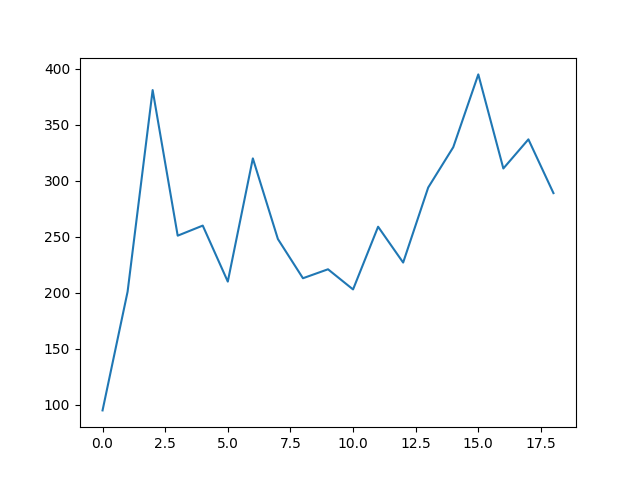

In [85]:
plt.figure()
plt.plot(num_reward_avg_all)

<IPython.core.display.Javascript object>


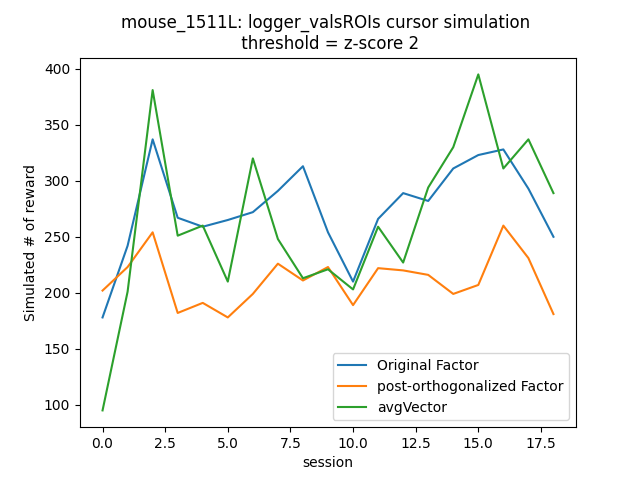

Text(0.5, 1.0, 'mouse_1511L: logger_valsROIs cursor simulation \n threshold = z-score 2')

In [86]:
plt.figure()
plt.plot(num_reward_all, label="Original Factor")
plt.plot(num_reward_ortho_all, label="post-orthogonalized Factor")
plt.plot(num_reward_avg_all, label="avgVector")
plt.legend()
plt.xlabel("session")
plt.ylabel("Simulated # of reward")
plt.title("mouse_1511L: logger_valsROIs cursor simulation \n threshold = z-score 2")

In [106]:
crossing_moment_all[0].shape

(169,)

In [115]:
cossim_ori_all, cossim_ortho_all = [], []

for ii, date in enumerate(dir_logger_valsROIs):
    # Where am I?
    print(date)
    
    # Load online vals_neurons value
    vals_neurons = scipy.io.loadmat(date)['logger_valsROIs']
    
    # Remove NaN timepoints to correctly calculate moving Z-score
    vals_neurons_clean = vals_neurons[~np.isnan(vals_neurons).any(axis=1)]
    vals_neurons_zscore = welford_moving_2D.make_rollingZScore(vals_neurons_clean, win_roll=int(Fs*60*15))
    vals_neurons_zscore = np.nan_to_num(vals_neurons_zscore)
    
    # Calculate cossim
    cossim_ori = (vals_neurons_zscore @ decoder_ori) / (np.linalg.norm(vals_neurons_zscore)) / (np.linalg.norm(decoder_ori))
    cossim_ortho = vals_neurons_zscore @ decoder_ortho / (np.linalg.norm(vals_neurons_zscore)) / (np.linalg.norm(decoder_ortho))

    # Append
    cossim_ori_all.append(cossim_ori)
    cossim_ortho_all.append(cossim_ortho)

/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230112/analysis_data/logger_valsROIs.mat


100%|██████████| 104914/104914 [00:13<00:00, 7734.75it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230113/analysis_data/logger_valsROIs.mat


100%|██████████| 104900/104900 [00:13<00:00, 7656.18it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230114/analysis_data/logger_valsROIs.mat


100%|██████████| 104880/104880 [00:14<00:00, 7367.70it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230115/analysis_data/logger_valsROIs.mat


100%|██████████| 104894/104894 [00:14<00:00, 7475.35it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230116/analysis_data/logger_valsROIs.mat


100%|██████████| 104902/104902 [00:14<00:00, 7262.66it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230117/analysis_data/logger_valsROIs.mat


100%|██████████| 104915/104915 [00:13<00:00, 7528.57it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230118/analysis_data/logger_valsROIs.mat


100%|██████████| 104854/104854 [00:13<00:00, 7674.81it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230119/analysis_data/logger_valsROIs.mat


100%|██████████| 104440/104440 [00:13<00:00, 7674.16it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230120/analysis_data/logger_valsROIs.mat


100%|██████████| 90441/90441 [00:12<00:00, 7360.74it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230121/analysis_data/logger_valsROIs.mat


100%|██████████| 104950/104950 [00:13<00:00, 7754.31it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230122/analysis_data/logger_valsROIs.mat


100%|██████████| 104845/104845 [00:13<00:00, 7870.15it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230123/analysis_data/logger_valsROIs.mat


100%|██████████| 104911/104911 [00:13<00:00, 7819.25it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230124/analysis_data/logger_valsROIs.mat


100%|██████████| 85039/85039 [00:10<00:00, 7793.04it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230125/analysis_data/logger_valsROIs.mat


100%|██████████| 82244/82244 [00:10<00:00, 7900.40it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230126/analysis_data/logger_valsROIs.mat


100%|██████████| 104840/104840 [00:13<00:00, 7670.59it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230127/analysis_data/logger_valsROIs.mat


100%|██████████| 104882/104882 [00:14<00:00, 7269.96it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230128/analysis_data/logger_valsROIs.mat


100%|██████████| 104947/104947 [00:13<00:00, 7587.05it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230129/analysis_data/logger_valsROIs.mat


100%|██████████| 104931/104931 [00:14<00:00, 7331.02it/s]


/n/data1/hms/neurobio/sabatini/gyu/data/full_data/mouse_1511L/20230130/analysis_data/logger_valsROIs.mat


100%|██████████| 104915/104915 [00:14<00:00, 7073.22it/s]


In [116]:
cossim_cross_all, cossim_cross_ortho_all = [], []

for ii, date in enumerate(dir_logger_valsROIs):
    cossim_cross_all.append(cossim_ori_all[ii][crossing_moment_all[ii]].mean())
    cossim_cross_ortho_all.append(cossim_ortho_all[ii][crossing_moment_ortho_all[ii]].mean())

<IPython.core.display.Javascript object>


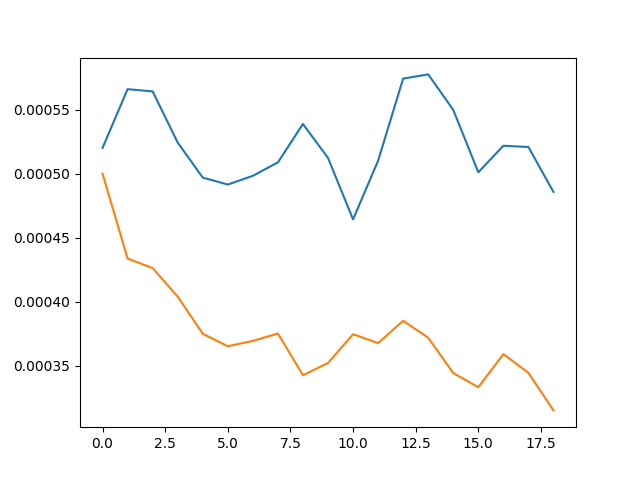

In [117]:
plt.figure()
plt.plot(cossim_cross_all)
plt.plot(cossim_cross_ortho_all)